<h1>Implicit Feature Extraction</h1>

This notebook contains the process of extraction for implicit features, using doc2vec by Gensim.
(check here for more info: https://radimrehurek.com/gensim/models/doc2vec.html)

The goal is to obtain the Perceptual Tuple from every reviews for the Experience Items available.


<h2>Feature Extraction using Doc2vec</h2>

In this section, we go through the process of training and testing a doc2vec model from Amazon User Reviews. The goal is to create high-dimensional vectors with latent features of the reviews. Doc2vec is a neural network that creates document (review) embeddings in a vector space. This is a high dimensional space, for example 100 dimensions. These vectors will later be used to try and cluster the reviews by the features the users care about and how they write about them.

In [19]:
from gensim import models
from random import shuffle
from nltk.tokenize import word_tokenize
import json
import multiprocessing
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim.models.doc2vec
import numpy as np
from pprint import pprint
import pyodbc
from contextlib import contextmanager
import sys

The data is extracted from a json file obtained from the UCSD website, http://jmcauley.ucsd.edu/data/amazon/ and it's formatted like this:

{

  "reviewerID": "A2SUAM1J3GNN3B",
  
  "asin": "0000013714",
  
  "reviewerName": "J. McDonald",
  
  "helpful": [2, 3],
  
  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",
  
  "overall": 5.0,
  
  "summary": "Heavenly Highway Hymns",
  
  "unixReviewTime": 1252800000,
  
  "reviewTime": "09 13, 2009"
  
}


In [2]:
data = []
with open('Pet_Supplies_5.json') as f:
    for line in f:
        data.append(json.loads(line))

Then the reviews have to be introduced into a LabeledSentence format consisting of unicode separate words (which form the "documents" of doc2vec) and a label. In this case, the label is created by adding the reviewer id with the product id from Amazon, such as 'A3UF8X1S0ZZ8KR|B000WUVZCK'. The text is tokenized and we only take in account reviews longer than 20 tokens to avoid meaningless text like "perfect", "just as expected", "not what we wanted", etc.

In [3]:
sentences = []

for l in range(len(data)):
    sentence = models.doc2vec.LabeledSentence(
        words = word_tokenize(data[l]['reviewText'].lower()), 
        tags = [data[l]['reviewerID']+'|'+data[l]['asin']])
    if len(sentence[0]) > 20:
        sentences.append(sentence)

print('Total reviews introduced: ', len(sentences))

Total reviews introduced:  155847


This is how a Labeled Sentence looks like:

In [4]:
sentences[0]

LabeledSentence(words=['i', 'purchased', 'the', 'trilogy', 'with', 'hoping', 'my', 'two', 'cats', ',', 'age', '3', 'and', '5', 'would', 'be', 'interested', '.', 'the', '3', 'yr', 'old', 'cat', 'was', 'fascinated', 'for', 'about', '15', 'minutes', 'but', 'when', 'the', 'same', 'pictures', 'came', 'on', ',', 'she', 'got', 'bored', '.', 'the', '5', 'year', 'old', 'watched', 'for', 'about', 'a', 'few', 'minutes', 'but', 'then', 'walked', 'away', '.', 'it', 'is', 'possible', 'that', 'because', 'we', 'have', 'a', 'wonderful', 'courtyard', 'full', 'of', 'greenery', 'and', 'trees', 'and', 'one', 'of', 'my', 'neighbors', 'has', 'a', 'bird', 'feeder', ',', 'that', 'there', 'is', 'enough', 'going', 'on', 'outside', 'that', 'they', 'prefer', 'real', 'life', 'versus', 'a', 'taped', 'version', '.', 'i', 'will', 'more', 'than', 'likely', 'pass', 'this', 'on', 'to', 'a', 'friend', 'who', 'has', 'cats', 'that', 'do', "n't", 'have', 'as', 'much', 'wildlife', 'to', 'watch', 'as', 'mine', 'do', '.'], tags

Note: If models are already available, skip to model loading. If not, continue here

Then we build the model with parameters tuned by trial and error, initially based on the inforamtion established in the paper of the experiment of Le & Mikolov ["Distributed Representations of Sentences and Documents"](http://cs.stanford.edu/~quocle/paragraph_vector.pdf), and an example by gensim on IMDB [doc2vec & IMDB](http://localhost:8888/notebooks/GitHub/gensim/docs/notebooks/doc2vec-IMDB.ipynb):

* `size` of 100-dimensional vectors, as the 400d vectors of the paper don't seem to offer much benefit on this task
* The `window` is kept at 10 since it showed good performance with documents of similar size
* Similarly, frequent word subsampling (restricting the amount of times that words can appear) seems to decrease sentiment-prediction accuracy, so it's left out.
* `dm=0` and `dbow_words=1` means 'skip-gram' (PV-DBOW) mode, a distributed bag of words
* `dm=1` defines the training algorithm 'distributed memory' (PV-DM) 
* A `min_count=2` saves quite a bit of model memory, discarding only words that only appear twice or once (and are thus no more expressive than the unique-to-each doc vectors themselves)
* More `workers` allow faster processing when possibe
* `alpha` is the initial learning rate, and will decrease linearly to min_alpha. In this case we keep it fixed to avoid decay.

In [ ]:
assert gensim.models.doc2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"

model_dm = models.Doc2Vec(dm=1, dm_mean=1, size=100, window=10, min_count=3, workers=multiprocessing.cpu_count(), alpha=.025, min_alpha=.025)
#model.build_vocab(sentences)

model_dbow = models.Doc2Vec(dm=0, dbow_words=1, size=100, window=10, min_count=3, workers=multiprocessing.cpu_count())


In [ ]:
model_dbow.build_vocab(sentences)
print(str(model_dbow))

model_dm.build_vocab(sentences)
print(str(model_dm))

In order to be sure there are no overlapping tags, here we check whether the amount of created vectors us the same as the amount of documents put into each model.

In [ ]:
assert len(model_dbow.docvecs) == len(sentences), "there are overlapping section titles! {0} docvecs and {1} documents".format(len(model.docvecs), len(sentences))
assert len(model_dm.docvecs) == len(sentences), "there are overlapping section titles! {0} docvecs and {1} documents".format(len(model.docvecs), len(sentences))

Here we train the dbow model for a set number of iterations

In [ ]:
for epoch in range(10):
    print("Training doc2vec_dbow model, epoch {}".format(epoch))
    #Randomly shuffle sentences for better training
    shuffle(sentences)    
    model_dbow.train(sentences)
    model_dbow.min_alpha = model_dbow.alpha # fix the learning rate, no decay

Now the dm model

In [ ]:
for epoch in range(10):
    print("Training doc2vec_dm model, epoch {}".format(epoch))    
    #Randomly shuffle sentences for better training
    shuffle(sentences)    
    model_dm.train(sentences)
    model_dm.min_alpha = model_dm.alpha # fix the learning rate, no decay

Then we save both models and test the similarity of a document with itself, as a naive sanity check

In [4]:
#model_dm.save("PetRev_dm10epoch.doc2vec")
#model_dbow.save("PetRev_dbow10epoch.doc2vec")

#model_dm = Doc2Vec.load("PetRev_dm10epoch.doc2vec")
model_dbow = Doc2Vec.load("PetRev_dbow10epoch.doc2vec")

In [7]:
test_dbow = model_dbow.docvecs.similarity( d1='A3UF8X1S0ZZ8KR|B000WUVZCK', d2='A3UF8X1S0ZZ8KR|B000WUVZCK')
#test_dm = model_dm.docvecs.similarity( d1='A3UF8X1S0ZZ8KR|B000WUVZCK', d2='A3UF8X1S0ZZ8KR|B000WUVZCK')
print('Similarity of the document A3UF8X1S0ZZ8KR|B000WUVZCK to itself is ', test_dbow, ' for dbow, and ', test_dm, 'for dm.')

Similarity of the document A3UF8X1S0ZZ8KR|B000WUVZCK to itself is  1.0  for dbow, and 


(None,)

Now we create a dictionary with the labels as keys and text as value, for easier reading and qualitative analysis

In [8]:
inverted_sentences = {}

for x in range(len(sentences)):
    a = sentences[x][1][0]
    b = ' '.join(sentences[x][0])
    inverted_sentences[a] = b

Here we can get a given ID and their most similar sentences by both models. 

In [9]:
dbow_sim = model_dbow.docvecs.most_similar(positive=["A3UF8X1S0ZZ8KR|B000WUVZCK"], topn=500)
#dm_sim = model_dm.docvecs.most_similar(positive=["A3UF8X1S0ZZ8KR|B000WUVZCK"], topn=500)

In [10]:
print('--Top 5 similar reviews in dbow to: ', inverted_sentences["A3UF8X1S0ZZ8KR|B000WUVZCK"]+'\n')
for x in range(5):
    print('ID: ', dbow_sim[x][0], ' Review: ',inverted_sentences[dbow_sim[x][0]]+'\n')

#print('--Top 5 similar reviews in dm to: ', inverted_sentences["A3UF8X1S0ZZ8KR|B000WUVZCK"]+'\n')
#for x in range(5):
#    print('ID: ', dm_sim[x][0], ' Review: ',inverted_sentences[dm_sim[x][0]]+'\n')

--Top 5 similar reviews in dbow to:  these are one of my two cats favorite treats . as soon as they hear the bag crinkle they come running !

ID:  A2ZV8W46FZWCLJ|B008PNN8C6  Review:  my cats adore these , all i have to do is rattle the package and they come running . definitely a hit !

ID:  A165CAFHYB29EY|B008FXKOI2  Review:  my cats love these treats . they run from all over when they hear the bag rattle . and they seem to be good for them as well .

ID:  A1AHLKY5GIC0ZX|B0012KB4U2  Review:  i stocked up on these as it is the one treat besides catnip that our cats love . the minute they hear the bag rattle , the 2 of them come running .

ID:  A1NLZDMM0GS268|B0029O10P4  Review:  as soon as they hear me pick up the bag , the cats come running ! they absolutely love these treats ! ! i put these on subscription so my spoiled kitties wo n't run out . =^..^=

ID:  A16GHVHVCMN80Z|B00BP2CKXW  Review:  i have three cats and they all love these treats . as soon as i open the package , they run 

Similar procedure with a random sentence, for curiosity

In [10]:
r = np.random.randint(len(sentences))

dbow_sim2 = model_dbow.docvecs.most_similar(positive=sentences[r][1], topn=5)
print('Top 5 similar reviews in dbow to: ', inverted_sentences[sentences[r][1][0]]+'\n')
for x in range(5):
    print('ID: ', dbow_sim2[x][0], ' Review: ',inverted_sentences[dbow_sim2[x][0]]+'\n')
    
dm_sim2 = model_dm.docvecs.most_similar(positive=sentences[r][1], topn=5)
print('Top 5 similar reviews in dm to: ', inverted_sentences[sentences[r][1][0]]+'\n')
for x in range(5):
    print('ID: ', dm_sim2[x][0], ' Review: ',inverted_sentences[dm_sim2[x][0]]+'\n')

Top 5 similar reviews in dbow to:  as so many other reviewers stated , seven pounds of milk bones is a lot but i store them in a large storage bin that is tightly sealed as i do her dog food . i have fed previous four-legged companions milk bones and remembered how much they enjoyed their milk bone treats and decided to treat our lhasa . she loves them and for her , i break them in half so i can give her several every day .

ID:  A1BBCMQSEJN0PP|B00INTTDQC  Review:  my dog was eager to try these . unlike other snacks , i limit her to one only . she threw up after eating twol

ID:  A2MM5OQCXV4BQ1|B0002H3S5K  Review:  i love these food vaults . i own 6 of them , two for pet food , and four for the various kinds of flour that i use for baking , since they 're made of food-grade plastic . they hold a 30 lb bag of large-bite dog kibble , although it 's a tight fit . when i 've bought small-bite kibble , it packed tighter and fit better.and these easily hold a 50 lb bag of bread flour . i hav

In [11]:
from collections import defaultdict

s = sentences
dd = defaultdict(list)

for i in range(len(sentences)):
    s = sentences[i][1][0]
    asin = s[(s.index('|')+1):]
    dd[asin].append(i)

for key in dd:
    if len(dd[key]) > 350:
        print(key)

B00008DFGY
B0002DHV16
B0002I0O60
B0007A0AQM
B0009X29WK
B000JQALA4
B001LWRFW2
B001VJ0B0I
B002CJIPEK
B003ARUKTG
B0040QOYZ2


Here we obtain the products with the most reviews, for example:
* B0007A0AQM - Zuke's Mini Naturals Dog Treats
* B000JQALA4 - GREENIES Treat-Pak for Dogs
* B002CJIPEK - Chef Michael's Grilled Sirloin Dry Dog Food
* B0002I0O60 - Plush Squeaking Toys for Dogs

B0002DHV16
B0007A0AQM
B0009X29WK
B000JQALA4
B003ARUKTG
B002CJIPEK
B0002I0O60


In [32]:
for x in range(len(data)):
    if data[x]['asin'] == 'B00008DFGY':
        print(data[x])

{'asin': 'B00008DFGY', 'reviewerName': '2manytoyz "2manytoyz"', 'helpful': [0, 0], 'unixReviewTime': 1385251200, 'summary': 'great for me', 'reviewTime': '11 24, 2013', 'reviewerID': 'AAXAKFQEAQPWC', 'overall': 5.0, 'reviewText': "Some people are complaining front line no longer works.  I wonder if those people have other intentions by saying this.  I've used frontline for years with no problem."}
{'asin': 'B00008DFGY', 'reviewerName': '4 Paws Country Inn', 'helpful': [0, 0], 'unixReviewTime': 1333756800, 'summary': 'Works excellent and great price', 'reviewTime': '04 7, 2012', 'reviewerID': 'A2HK361BNFAPEE', 'overall': 5.0, 'reviewText': 'Frontline Plus for Dogs 3 Mths 89-132 LbsI have tried other brands and nothing compares to Frontline.This is the best price I have found.'}
{'asin': 'B00008DFGY', 'reviewerName': 'A. Dent "Aragorn"', 'helpful': [0, 0], 'unixReviewTime': 1222732800, 'summary': 'Effective but a bit expensive', 'reviewTime': '09 30, 2008', 'reviewerID': 'ADLVFFE4VBT8', 

{'asin': 'B00008DFGY', 'reviewerName': 'Amazon Customer', 'helpful': [0, 0], 'unixReviewTime': 1347840000, 'summary': 'Flea Med', 'reviewTime': '09 17, 2012', 'reviewerID': 'A2D4TTRGISWICH', 'overall': 5.0, 'reviewText': 'This is by far the cheapest I have found the Frontline Preventative and I have been using Frontline for many years.  Very happy with my purchase!'}
{'asin': 'B00008DFGY', 'reviewerName': 'Amazon Customer', 'helpful': [0, 0], 'unixReviewTime': 1393718400, 'summary': 'Easy to use', 'reviewTime': '03 2, 2014', 'reviewerID': 'A3HUDCVKZ72BWU', 'overall': 4.0, 'reviewText': 'This was easy to use and applied nicely on to my dog.  Amazon is one of the cheapest places that I have found this.  My dog did not like it much and he tried to get it off the back of his neck.  I am not sure if he had a reaction to it, and that is why he was trying to get it off, or my dog could have just been playing around.'}
{'asin': 'B00008DFGY', 'reviewerName': 'Amazon Customer', 'helpful': [1, 1]

In [35]:
def product_similars_model(review_id, number):    
    dbow_sim = model_dbow.docvecs.most_similar(positive=[review_id], topn=10000)
    print('Top similar reviews in dbow to: ', inverted_sentences[review_id]+'\n')
    i = 0
    for x in range(len(dbow_sim)):
        s = dbow_sim[x][0]
        values = s[(s.index('|'))+1:]
        if i < number+1:
            if values == review_id[(review_id.index('|'))+1:]:
                print('ID: ', dbow_sim[x][0], ' Review: ',inverted_sentences[dbow_sim[x][0]]+'\n')
                i = i + 1

In [37]:
product_similars_model('A23ORRLCW4AJB0|B00008DFGY', 5)
product_similars_model('A3T4OHEAHOJ700|B00008DFGY', 5)
product_similars_model('A2QFW4HIDXFDP3|B00008DFGY', 5)

Top similar reviews in dbow to:  i put it on my dog and in less than a week she was itching fleas again ! ! ! dosent work dosent work do n't waste your money

ID:  A37KQ2QVXLNYP3|B00008DFGY  Review:  the day after application my dog was off his feed and was lethargic . my vet recommended some benadryl and that worked . she was her normal self the next day .

ID:  A2Q4YPDDJUGELE|B00008DFGY  Review:  after trying petarmour which did n't work , i read all the reviews on frontline and tried it . it did not work either ! ! ! 5/10/13 update : capstar is a great product , it got rid of the fleas on the dog within 30 mins and then we followed up with the k9 advantix ii . has been 3 weeks & both of these products worked wonderfully and we will continue to buy them . wasted money on petarmour and frontline , do n't do it .

ID:  A2WUWAVZF4WCJE|B00008DFGY  Review:  this stuff did not work ! do not buy this , its weak and not water proof.my house was covered and my dogs were loaded ! ! it only wor

In here, we can infer the vector of a given sentence (separated by words like at the beginning) and test how similar it is to others. This is important to get vectors from new sentences that were not in the training set for the model. In this case we try it with a sentence that is in the dataset, to see which ones are the most similar. The first sentence should be itself.

Higher steps in the inference process will achieve a better similarity score to itself, while reducing it to the others.

In [ ]:
x = np.random.randint(len(sentences))

print('ID = ',sentences[x][1][0], ' text = ', inverted_sentences[sentences[x][1][0]])

inferred_docvec = model_dbow.infer_vector(word_tokenize(inverted_sentences[sentences[x][1][0]]), steps=5000, alpha = 0.01)
pprint('%s:\n %s' % (model_dbow, model_dbow.docvecs.most_similar([inferred_docvec], topn=5)))

inferred_docvec = model_dm.infer_vector(word_tokenize(inverted_sentences[sentences[x][1][0]]), steps=5000, alpha = 0.01)
pprint('%s:\n %s' % (model_dm, model_dm.docvecs.most_similar([inferred_docvec], topn=5)))

Now we can try to visualize the vector as a line and compare it to its word-based inference.

In [ ]:
# We can choose any sentence and print its vector, as well as the inferred vector of the review's words. 
# Then we can also plot the vector as a line and compare it to the model inference of itself.

#print(model_dbow.docvecs[sentences[x][1][0]])
#print(model_dm.infer_vector(word_tokenize(inverted_sentences[sentences[x][1][0]]), steps=1000, alpha = 0.01))
#model_dbow.docvecs[sentences[x][1][0]] - model_dm.infer_vector(word_tokenize(inverted_sentences[sentences[x][1][0]]))

# With dbow
import matplotlib.pyplot as plt
plt.plot(model_dbow.docvecs[sentences[x][1][0]], alpha = 0.8, linestyle='dotted', color='black', label='vector')
plt.plot(model_dbow.infer_vector(word_tokenize(inverted_sentences[sentences[x][1][0]]), steps=5000, alpha = 0.01), alpha = 0.5, color = 'green', label = 'dbow')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# With dm
plt.plot(model_dm.docvecs[sentences[x][1][0]], alpha = 0.8, linestyle='dotted', color='black', label='vector')
#plt.plot(model_dm.infer_vector(word_tokenize('Digitalisation is rapidly changing the world. Besides looking at the past, companies need to know what is happening now and anticipate what is going to happen. Large data volumes, data variety and the speed of data are only increasing and it is our mission to ensure organisations have as much relevant and valuable information as possible'), steps=5000, alpha = 0.01), alpha = 0.3, color='green', label = 'random')
plt.plot(model_dm.infer_vector(word_tokenize(inverted_sentences[sentences[x][1][0]]), steps=5000, alpha = 0.01), alpha = 0.3, color='red', label = 'dm')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Some unrelated sentence by both models
plt.plot(model_dm.infer_vector(word_tokenize('Digitalisation is rapidly changing the world. Besides looking at the past, companies need to know what is happening now and anticipate what is going to happen. Large data volumes, data variety and the speed of data are only increasing and it is our mission to ensure organisations have as much relevant and valuable information as possible'), steps=5000, alpha = 0.01), alpha = 0.3, color='red', label = 'random_dm')
plt.plot(model_dbow.infer_vector(word_tokenize('Digitalisation is rapidly changing the world. Besides looking at the past, companies need to know what is happening now and anticipate what is going to happen. Large data volumes, data variety and the speed of data are only increasing and it is our mission to ensure organisations have as much relevant and valuable information as possible'), steps=5000, alpha = 0.01), alpha = 0.3, color='green', label = 'random_dbow')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [20]:
dataXd.shape

(155847, 100)

<h2>Clustering</h2>
In this section we perform graphical comparisons of distinct clustering algorithms to check parameters and behavior, as well as some exploratory analysis. 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
import time
from mpl_toolkits.mplot3d import Axes3D
import hdbscan
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

Create sets of 2, 3 and X dimensions with a number of instances for clustering and exploration.

In [13]:
# For a 2 dimensional plot
vectors = []
dimensions = 2
for x in range(10000):      
    vector = []
    for y in range(dimensions):
        #id = sentences[x][1][0]
        a = model_dbow.docvecs[sentences[x][1][0]][y]    
        vector.append(a)
    vectors.append(vector)

# For a 3 dimensional plot
vectors3d = []    
dimensions = 3
for x in range(10000):      
    vector = []
    for y in range(dimensions):
        #id = sentences[x][1][0]
        a = model_dbow.docvecs[sentences[x][1][0]][y]    
        vector.append(a)
    vectors3d.append(vector)

# For a X dimensional analysis, can be plotted on both 2d and 3d for visualization
vectorsXd = []
dimensions = 100
for x in range(len(sentences)):      
    vector = []
    for y in range(dimensions):
        a = model_dbow.docvecs[sentences[x][1][0]][y]    
        vector.append(a)
    vectorsXd.append(vector)
    
# Convert to arrays
data2d = np.array(vectors)
data3d = np.array(vectors3d)
dataXd = np.array(vectorsXd)

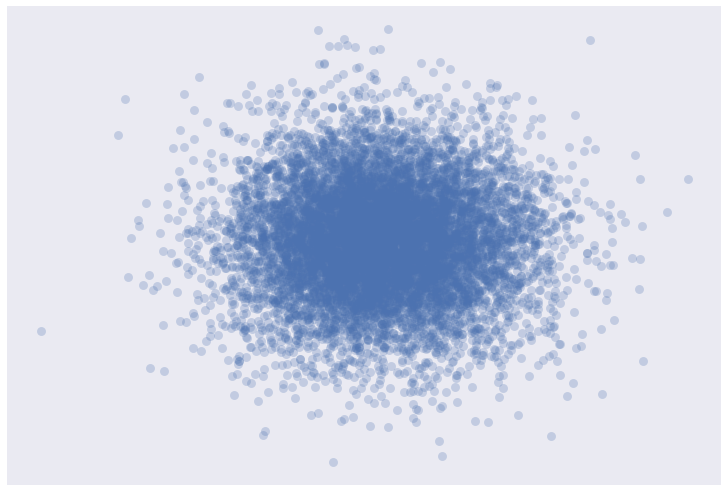

In [9]:
plt.scatter(data.T[0], data.T[1], c='b', **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

These are the plotting functions, they take the data introduced, execute the clustering algorithms, and map the first 2 or 3 dimensions of the data, respectively, colored by cluster. The main algorithms accepted are from sklearn, with their parameters: 
* plot_clusters(data, cluster.KMeans, (), {'n_clusters':6})
* plot_clusters(data, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})
* plot_clusters(data, cluster.MeanShift, (0.175,), {'cluster_all':False})
* plot_clusters(data, cluster.SpectralClustering, (), {'n_clusters':6})
* plot_clusters(data, cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})
* plot_clusters(data, cluster.DBSCAN, (), {'eps':0.025})
* plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':15})

Review documentation if necessary.

In [56]:
def plot_clusters(data, algorithm, args, kwds):
    """
    (list, string, args) -> None
    Returns a scatterplot in 2d of the clusters created from the data with the indicated algorithm. 
    The plot is with the first 2 dimentions of the data, regardless of dimentionality.
    """
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    clusters = np.unique(labels).max()+1
    palette = sns.color_palette('bright', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    frame.set_xlabel('x_axis')
    frame.set_ylabel('y_axis')
    plt.text(-1.5, -1.2, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    plt.text(-1.5, -1.4, 'Number of clusters ={}'.format(str(clusters)), fontsize=14)
    plt.ylim([-2,2])
    plt.xlim([-2,2])
    
def plot_clusters3d(data, algorithm, args, kwds):
    """
    (list, string, args) -> None
    Returns a scatterplot in 3d of the clusters created from the data with the indicated algorithm. 
    The plot is with the first 3 dimentions of the data, regardless of dimentionality.
    """
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    clusters = np.unique(labels).max()+1
    palette = sns.color_palette('bright', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('x_axis')
    ax.set_ylabel('y_axis')
    ax.scatter(data.T[0], data.T[1], data.T[2], zdir='y', c=colors, **plot_kwds)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    #plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    ax.text(-1.5,-1.3,-1.3, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    ax.text(-1.5,-1.5,-1.5, 'Number of clusters ={}'.format(str(clusters)), fontsize=14)
    
def cluster_centroids(X, num_clusters):
    km = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1, verbose=False)
    km.fit(X)
    # save the classifier
    

    #original_space_centroids = svd.inverse_transform(km.cluster_centers_)
    #order_centroids = original_space_centroids.argsort()[:, ::-1]
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]


    #with open('co_occur_K_means_{}_{}_tuned_datapipelines_final_lowercase.csv'.format(num_clusters), 'w', encoding= 'UTF-8') as f:

    term_list = range(len(X))
    #f.write("Top terms with {} clusters".format(num_clusters))
    #f.write('\n')
    print("Top terms with {} clusters".format(num_clusters))
    for i in range(len(order_centroids)):
        num_term = 0
        #f.write("Annotate Here,Cluster {}:".format(i))
        print("Annotate Here,Cluster {}:".format(i))
        for ind in order_centroids[i, :10]:
            #print(',{}'.format(term_list[ind]))
            #for  indx_clus in np.where(km.labels_ == i)[0]:
            #    if ind == indx_clus:
            #        if num_term >=5:
            #            continue
            #        else:
            #            num_term+=1
                        #f.write(',{}'.format(term_list[ind]))
            print(',{}'.format(ind))

        #f.write("\n")

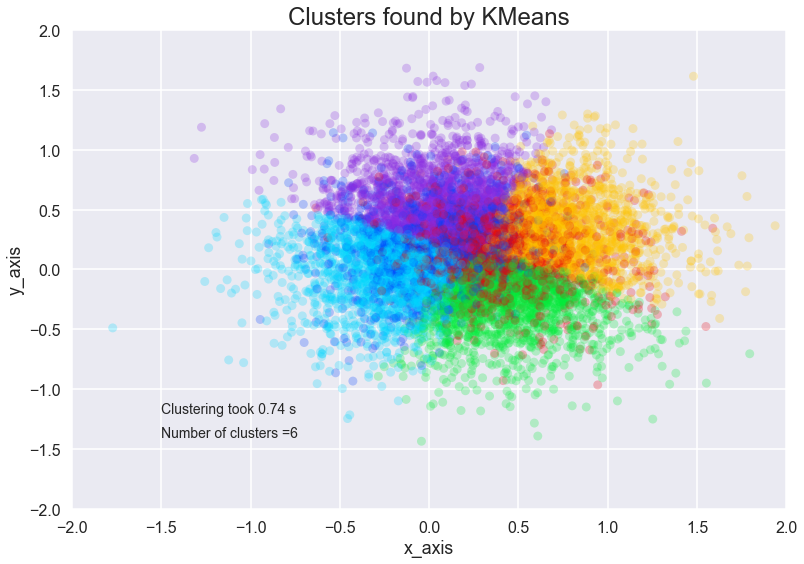

In [13]:
#plot_clusters(dataXd,  cluster.KMeans, (), {'n_clusters':6})
#plot_clusters(data,  hdbscan.RobustSingleLinkage, (), {'cut':0.15, 'k':30})
plot_clusters(data3d,  cluster.KMeans, (), {'n_clusters':6})
#plot_clusters(dataXd,  cluster.DBSCAN, (), {'eps':4.3, 'min_samples':3})

#plot_clusters3d(dataXd,  cluster.KMeans, (), {'n_clusters':4})
#plot_clusters3d(dataXd,  cluster.KMeans, (), {'n_clusters':6})
#plot_clusters3d(data3d,  hdbscan.RobustSingleLinkage, (), {'cut':0.2, 'k':30})


#plot_clusters(data, cluster.DBSCAN, (), {'eps':0.06, 'min_samples':3})#, 'metric':'euclidean'})
#plot_clusters3d(dataXd, cluster.DBSCAN, (), {'eps':4.3, 'min_samples':3})#, 'metric':'euclidean'})

In [1]:
cluster_centroids(dataXd_t, 5)
#dataXd.shape
#len(order)

NameError: name 'cluster_centroids' is not defined

In [55]:
sentences[92292]

LabeledSentence(words=['you', 'have', 'to', 'scoop', ',', 'of', 'course', '.', 'my', 'cats', 'do', 'not', 'like', 'a', 'clumpy', 'dirty', 'litter', 'box', ',', 'and', 'yours', 'probably', 'do', "n't", 'either', '.', 'that', 'said', ',', 'you', 'can', 'not', 'get', 'every', 'microscopic', 'molecule', 'of', 'waste', 'out', 'by', 'scooping', ',', 'even', 'with', 'clumping', 'litter', '...', '.so', 'the', 'remnants', 'are', 'still', 'there', ',', 'and', 'you', 'do', "n't", 'want', 'to', 'throw', 'out', 'basically', 'good', 'litter', 'because', 'it', 'smells', 'bad', 'even', 'though', 'it', 'looks', 'clean', 'enough', '.', 'this', 'spray', 'does', 'the', 'trick', '.', 'it', 'has', 'a', 'fresh', ',', '``', 'neutral', "''", 'odor', ',', 'not', 'flowery', 'or', 'piney', 'or', 'medicinal.after', 'scooping', ',', 'i', 'give', 'the', 'remaining', 'litter', 'in', 'the', 'box', 'a', 'couple', 'of', 'sqirts', 'of', 'the', 'arm', '&', 'hammer', 'spray', '.', 'then', 'i', 'put', 'a', 'handful', 'of', 

In [30]:
sentences[]

LabeledSentence(words=['save', 'your', 'money', ',', 'not', 'worth', 'the', 'price', '.', 'this', 'did', 'not', 'work', 'on', 'my', 'dogs', 'and', 'i', 'would', 'not', 'recommend', 'it', 'at', 'all', '.'], tags=['A1Q9O31E6O17EJ|9376674824'])

It doesn't look very good, it's all noisy in a cloud thanks to the `curse of dimentionality`. Let's try to get the most and least similar 500 vectors from a given sentence, and try to cluster and plot them using their full dimentions. Below, we do the same algorithm and same parameters but with the 500 least similar sentences to the same vector.

In [ ]:
dbow_sim = model_dbow.docvecs.most_similar(positive=["A3UF8X1S0ZZ8KR|B000WUVZCK"], topn=500)
dbow_dif = model_dbow.docvecs.most_similar(negative=["A3UF8X1S0ZZ8KR|B000WUVZCK"], topn=500)

In [ ]:
sim_vectorsXd = []
dimensions = 100
for x in range(len(dbow_sim)):      
    vector = []
    for y in range(dimensions):
        a = model_dbow.docvecs[dbow_sim[x][0]][y]    
        vector.append(a)
    sim_vectorsXd.append(vector)

dif_vectorsXd = []
for x in range(len(dbow_dif)):      
    vector = []
    for y in range(dimensions):
        a = model_dbow.docvecs[dbow_dif[x][0]][y]    
        vector.append(a)
    dif_vectorsXd.append(vector)
    
# Convert to arrays
sim_dataXd = np.array(sim_vectorsXd)
dif_dataXd = np.array(dif_vectorsXd)